# UMAP LEARN

## Plan

* Supervised and unupervised analysis on pulmonary carcinoid data :
    * Graph
    * Local neighborhood
    * Clustering Kmean - Dbscan - KNN ?
* Unsupervised analysis on pulmonary carcinoid data :
    * Graph
    * Local neighborhood
    * Clustering Kmean - Dbscan - KNN ?
    
*  Unsupervised analysis on pulmonary carcinoid data and PCA:

## Librairies

In [1]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib 
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit ,train_test_split
import umap
import math
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score , recall_score , silhouette_score, accuracy_score
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from scipy.spatial.distance import pdist
from matplotlib.colors import ListedColormap
from scipy.stats import mode
import itertools

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
import jaccard_set_distance as Neighborhood

## Function 

In [107]:
def label_pred(y_test, pred_label):
    """This function allows to assign cluster label with their orginal label.
    n_class is the number of class"""
    Assign_clustring_labels = pd.DataFrame()
    Assign_clustring_labels["y_test"] = y_test
    Assign_clustring_labels["pred_label"] = pred_label
    tab = pd.crosstab( Assign_clustring_labels["y_test"],  Assign_clustring_labels["pred_label"])
    print(tab)
    P = list(itertools.permutations(tab.columns.values))
    #print("P", P)
    original_labels = list(tab.index.values)
    #print('original_labels', original_labels)
    List_dict_label=[]
    for i in range(len(P)):
        dict_label = {}
        for j in range(len(original_labels)):
            dict_label[P[i][j]] =original_labels[j]
            List_dict_label.append(dict_label)
        
    acc_score=[]
    for i in range(len(List_dict_label)):
        c_dict = List_dict_label[i]
        #print('c_dict',c_dict)
        y_labels = []
        for j in range(len(pred_label)):
            y_labels.append(c_dict[pred_label[j]])
        acc_score.append(accuracy_score(y_labels, y_test))
        #print('c acc_score',accuracy_score(y_labels, y_test))
        
    f_acc_score = []    
    for i in range(0,len(acc_score), len(original_labels)):
        #print(i)
        f_acc_score.append(acc_score[i])
    
    #print("f_acc_score", f_acc_score)
    acc_score=f_acc_score
    #acc_score= list(set(acc_score))
   
    c_dict= {}
    print("acc_score", acc_score)
    #print("acc_score.index(max(acc_score))", acc_score.index(max(acc_score)))
    #print("P[acc_score.index(max(acc_score))]", P[acc_score.index(max(acc_score))])
    for j in range(len(original_labels)):
        c_dict[P[acc_score.index(max(acc_score))][j]]= original_labels[j]
    #c_dict ={ P[acc_score.index(max(acc_score))][0]:"Atypical",P[acc_score.index(max(acc_score))][1]:"Typical" ,P[acc_score.index(max(acc_score))][2]:"LCNEC" }
    print("c_dict",c_dict)
    final_label = []
    for j in range(len(pred_label)):
       # print("pred_label[j]", pred_label[j])
       # print("c_dict[pred_label[j]]", c_dict[pred_label[j]])
       # print('')
        final_label.append(c_dict[pred_label[j]])
    final_acc_score = accuracy_score(final_label, y_test)  
    
    return final_acc_score , final_label

## Import data 
* `data_lv_50_type` is the expression data frame of 6399 genes which have the largest variance for samples whose type is Atypical, Typical, or LCNEC
* `coords_mofa_expr_lnen` Mofa coords with expression data for LNEN samples

In [7]:
data_lv_50_type3 =  pd.read_csv("t_data_vst_50_type_3class.tsv", sep="\t")
data_lv_50_type3.shape
coords_mofa_expr_lnen = pd.read_csv("MOFA_Expr_coord_sort.txt", sep="\t")

In [8]:
coords_mofa_expr_lnen.head()
Sample_ID_df =pd.DataFrame(data_lv_50_type3["Sample_ID"] )
coords_mofa_expr_lnen_v2 = pd.merge(coords_mofa_expr_lnen, Sample_ID_df, on='Sample_ID', how='inner')
coords_mofa_expr_lnen = coords_mofa_expr_lnen_v2

**Set labels**

In [9]:
lv_50_type = data_lv_50_type3.iloc[:,6399]
typeN  = []
for i in range(len(lv_50_type)):
    if lv_50_type[i]== 'Atypical':
        typeN.append(1)
    elif lv_50_type[i]== 'Typical':
        typeN.append(2)
    elif lv_50_type[i]== 'LCNEC':
        typeN.append(3)
    else :
        print("WARNING i = ", i)
        break


## Effect of supervised analysis

### Graphical experiment

#### Unsupervised Dimensionality Reduction

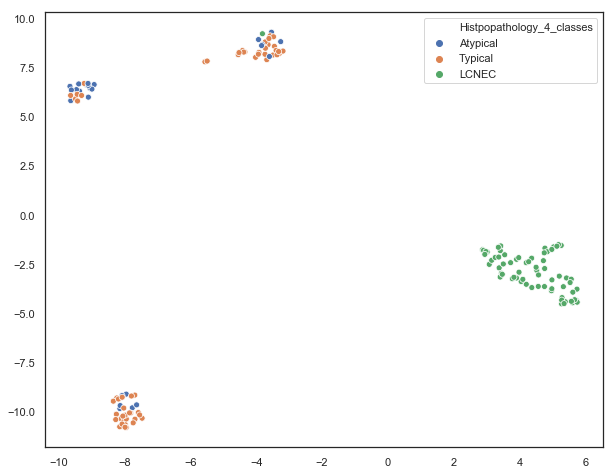

In [10]:
sns.set(style='white', rc={'figure.figsize':(10,8)})
lv_50_data = data_lv_50_type3.iloc[:,1:6398]
#lv_50_type = data_lv_50_type3.iloc[:,6399]
standard_embedding = umap.UMAP().fit_transform(lv_50_data)
sns.scatterplot(x=standard_embedding[:, 0], y=standard_embedding[:, 1],  hue=lv_50_type)
plt.show()

#### Supervised Dimensionality Reduction

In [11]:
embedding = umap.UMAP().fit_transform(lv_50_data, y=typeN)

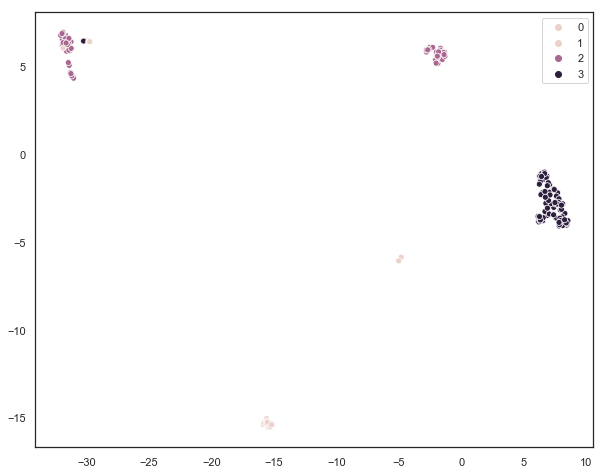

In [12]:
sns.set(style='white', rc={'figure.figsize':(10,8)})
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1],  hue=typeN)
plt.show()

**Legend complement :**
* 1 Atypical
* 2 Typical
* 3 LCNEC

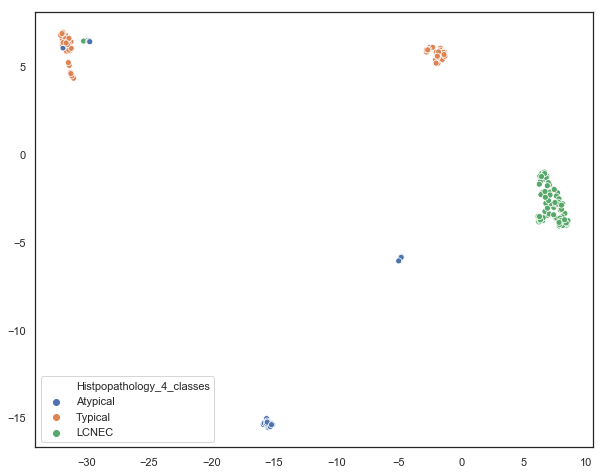

In [13]:
sns.set(style='white', rc={'figure.figsize':(10,8)})
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1],  hue=lv_50_type)
plt.show()

**Remark : New cluster of typical**
### Local Neighbohood metrics
##### Distance

In [14]:
standard_embedding_df=  pd.DataFrame(data_lv_50_type3.iloc[:,0])
standard_embedding_df['X'] = standard_embedding[:,0]
standard_embedding_df['Y'] = standard_embedding[:,1]
embedding_df = pd.DataFrame(data_lv_50_type3.iloc[:,0])
embedding_df['X'] = embedding[:,0]
embedding_df['Y'] = embedding[:,1]
d_unsupervised =  Neighborhood.distance_matrix(standard_embedding_df)
d_supervised = Neighborhood.distance_matrix(embedding_df)
Dist_pulmonary =  pd.read_csv("Distance_pulmo.txt", sep="\t") # "real distances" in Rn

In [15]:
d_mofa_expr = Neighborhood.distance_matrix(coords_mofa_expr_lnen)

#### Write Coords

In [16]:
#standard_embedding_df.to_csv(path_or_buf='Unsupervised_Coords.txt', sep='\t')
#embedding_df.to_csv(path_or_buf='Supervised_Coords.txt', sep='\t')

##### CP

In [17]:
#cp1 = Neighborhood.centrality_preservation(d_unsupervised ,  Dist_pulmonary , range(1,len(standard_embedding[:,0]),10),"CP_pulmo_R_unsupervised")
#cp2 = Neighborhood.centrality_preservation(d_supervised ,  Dist_pulmonary , range(1,len(standard_embedding[:,0]),10),"CP_pulmo_R_supervised")

In [18]:
#cp3 = Neighborhood.centrality_preservation(d_mofa_expr , Dist_pulmonary ,  range(1,d_mofa_expr.shape[0],10)  ,"CP_pulmo_R_MOFA")

**Results**

CP2 on projection CP2 unsupervised type :
http://rpubs.com/mathiane/UMAP_R_CP_Supervised
http://rpubs.com/mathiane/UMAP_R_US_CP2
Interprétation difficile

CPN on projection CP2 unsupervised type :
http://rpubs.com/mathiane/UMAP_R_US_CPN
http://rpubs.com/mathiane/UMAP_R_US_CPN_next


CP2 on projection CP2 supervised type :
http://rpubs.com/mathiane/UMAP_R_CP_Supervised
http://rpubs.com/mathiane/UMAP_R_CP_Sup_n
Interprétation difficile


CPN on projection CP2 supervised type :

http://rpubs.com/mathiane/UMAP_S_CPN
http://rpubs.com/mathiane/UMAP_S_CPN_next


**Centralité gobalement plus conservé dans le cas non supervisé**

![CPMeanbyk](cp_mean.png)

#### Seq and Set

In [711]:
#Neighborhood.main_f(d_unsupervised , Dist_pulmonary, d_supervised.shape[0] , "set_diff_pulmo_unsuper_R" , "seq_diff_pulmo_unsuper_R" , True )
#Neighborhood.main_f(d_supervised, Dist_pulmonary, d_supervised.shape[0] , "set_diff_pulmo_super_R" , "seq_diff_pulmo_super_R" , True )
#Neighborhood.main_f(d_mofa_expr, Dist_pulmonary, d_mofa_expr.shape[0] , "set_diff_pulmo_R_MOFA" , "seq_diff_pulmo_R_MOFA" , True )

![SetDiffbyk](set_Diff.png)
![SeqDiffbyk](seq_diff_by_k.png)

### Clustering

In [108]:
min_dist_to_test = np.arange(0,3, 1.5)
#n_neighbors_to_test = range(2,210)

In [109]:
data_lv_50_type3.head()
data_lv_50_type3.shape

(152, 6400)

##### Stratified cross validation

In [110]:
CV = train_test_split(lv_50_data,lv_50_type,lv_50_type )

In [111]:
X_train = CV[0]
X_test = CV[1]
y_train = CV[2]
y_test = CV[3]

In [112]:
y_test = list(y_test)
print('len y test', len(y_test))
print(y_test.count('LCNEC') , y_test.count('Typical') , y_test.count('Atypical'))
y_test.count('LCNEC')/len(y_test) , y_test.count('Typical')/len(y_test) , y_test.count('Atypical')/len(y_test)

len y test 38
14 18 6


(0.3684210526315789, 0.47368421052631576, 0.15789473684210525)

In [113]:
y_train = list(y_train)
y_train.count('LCNEC')/len(y_train) , y_train.count('Typical')/len(y_train) , y_train.count('Atypical')/len(y_train)

(0.4824561403508772, 0.3508771929824561, 0.16666666666666666)

In [114]:
lv_50_type = list(lv_50_type)
lv_50_type.count('LCNEC')/len(lv_50_type) , lv_50_type.count('Typical')/len(lv_50_type) , lv_50_type.count('Atypical')/len(lv_50_type)

(0.45394736842105265, 0.3815789473684211, 0.16447368421052633)

##### Without UMAP Preprocessing

In [115]:
knn_1 = KNeighborsClassifier().fit(X_train, y_train)
svc_1 = SVC().fit(X_train, y_train)
kmeans_1 = KMeans(n_clusters=3).fit(X_train)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [117]:
knn_1.fit(X_train, y_train)
pred_knn_1 = knn_1.predict(X_test)
pred_kmeans_1 = kmeans_1.predict(X_test)
kmean_acc_1 , kmean_lab_1 =label_pred(y_test, pred_kmeans_1 )
print("Knn accurancy  : ",knn_1.score(X_test, y_test))
print("SVC accurancy  : ",svc_1.score(X_test, y_test))
print("Kmeans accurancy  : ", kmean_acc_1)

pred_label  0   1   2
y_test               
Atypical    6   0   0
LCNEC       0  14   0
Typical     8   0  10
acc_score [0.7894736842105263, 0.15789473684210525, 0.2631578947368421, 0.21052631578947367, 0.0, 0.5789473684210527]
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.868421052631579
SVC accurancy  :  0.5526315789473685
Kmeans accurancy  :  0.7894736842105263


These scores presents classifiers' accury (TP/(TP+FP)).
##### Unsupervised UMAP Preprocessing

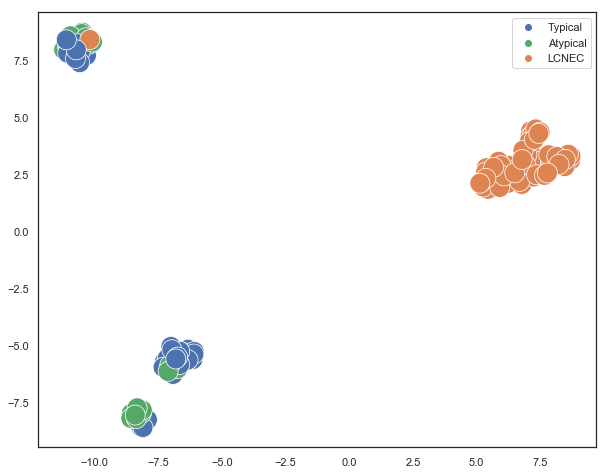

In [118]:
palette ={"Typical":"C0","LCNEC":"C1","Atypical":"C2"}
trans = umap.UMAP().fit(X_train)
sns.set(style='white', rc={'figure.figsize':(10,8)})
sns.scatterplot(x=trans.embedding_[:, 0], y=trans.embedding_[:, 1],  hue=y_train, palette =palette ,s=400)
plt.show()

In [119]:
svc_2 = SVC().fit(trans.embedding_, y_train)
knn_2 = KNeighborsClassifier().fit(trans.embedding_, y_train)
kmeans_2 = KMeans(n_clusters=3).fit(trans.embedding_, y_train)
test_embedding = trans.transform(X_test)
svc_pred_2= svc_2.predict(test_embedding)
knn_pred_2 = knn_2.predict(test_embedding)
kmeans_pred_2 = kmeans_2.predict(test_embedding)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


**Graph for KNN prediction**

In [120]:
edges_col = []
for i in knn_pred_2:
    if i == "Typical":
        edges_col.append("blue")
    elif i == "LCNEC":
        edges_col.append("orange")
    elif i == "Atypical":
        edges_col.append("lime")
    else :
        print("warning")

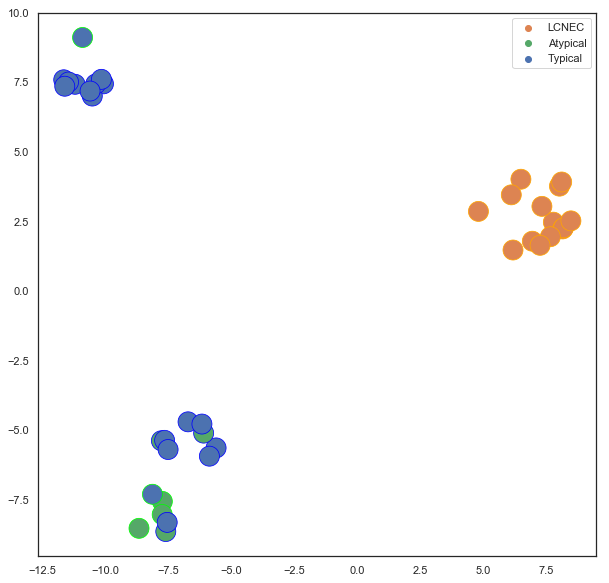

In [121]:
sns.set(style='white', rc={'figure.figsize':(10,10)})
sns.scatterplot(test_embedding[:, 0], test_embedding[:, 1],  hue=y_test, edgecolor=  edges_col ,s=400, palette =palette)
plt.show()

**Graph for Kmeans prediction**

In [122]:
kmean_acc_2 , kmean_lab_2 =label_pred(y_test, kmeans_pred_2 )

pred_label   0  1   2
y_test               
Atypical     0  6   0
LCNEC       14  0   0
Typical      0  8  10
acc_score [0.2631578947368421, 0.21052631578947367, 0.7894736842105263, 0.15789473684210525, 0.5789473684210527, 0.0]
c_dict {1: 'Atypical', 0: 'LCNEC', 2: 'Typical'}


In [123]:
edges_col = []
for i in kmean_lab_2:
    if i == "Typical":
        edges_col.append("blue")
    elif i == "LCNEC":
        edges_col.append("orange")
    elif i == "Atypical":
        edges_col.append("lime")
    else :
        print("warning")

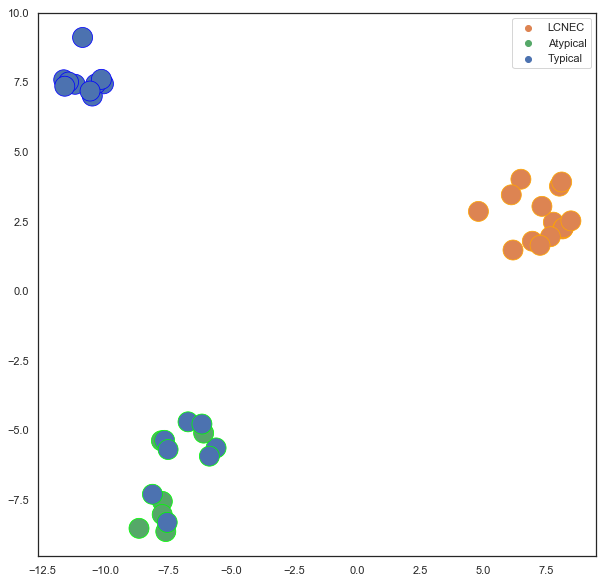

In [124]:
sns.set(style='white', rc={'figure.figsize':(10,10)})
sns.scatterplot(test_embedding[:, 0], test_embedding[:, 1],  hue=y_test, edgecolor=  edges_col ,s=400, palette =palette)
plt.show()

In [125]:
print("Knn accurancy  : ",knn_2.score(trans.transform(X_test), y_test) )
print("SVC accurancy  : ",svc_2.score(trans.transform(X_test), y_test) )
print("Kmeans accurancy  : ",kmean_acc_2 )

Knn accurancy  :  0.868421052631579
SVC accurancy  :  0.8947368421052632
Kmeans accurancy  :  0.7894736842105263


In [126]:
print("Knn silhouette score  : ",silhouette_score(trans.transform(X_test), knn_pred_2) )
print("Svc silhouette score  : ",silhouette_score(trans.transform(X_test), svc_pred_2) )
print("Kmeans silhouette score  : ",silhouette_score(trans.transform(X_test), kmeans_pred_2) )

Knn silhouette score  :  0.36219606
Svc silhouette score  :  0.49188796
Kmeans silhouette score  :  0.8893463


##### Supervised UMAP Preprocessing

In [128]:
y_train = list(y_train)

In [129]:
y_trainN  = []
for i in range(len(y_train)):
    if y_train[i]== 'Atypical':
        y_trainN.append(1)
    elif y_train[i]== 'Typical':
        y_trainN.append(2)
    elif y_train[i]== 'LCNEC':
        y_trainN.append(3)
    else :
        print("WARNING i = ", i)
        break

trans_sup = umap.UMAP().fit(X_train, y=y_trainN)

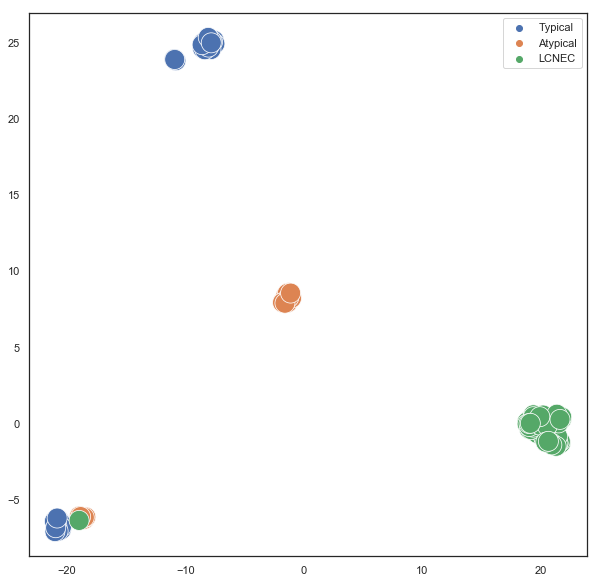

In [130]:
sns.set(style='white', rc={'figure.figsize':(10,10)})
sns.scatterplot(x=trans_sup.embedding_[:, 0], y=trans_sup.embedding_[:, 1],  hue=y_train ,s=400)
plt.show()

In [131]:
svc_3 = SVC().fit(trans_sup.embedding_, y_train)
knn_3 = KNeighborsClassifier().fit(trans_sup.embedding_, y_train)
kmeans_3 = KMeans(n_clusters=3).fit(trans_sup.embedding_, y_train)
test_sup_embedding = trans_sup.transform(X_test)
#test_pred = knn.predict(test_embedding)
svc_pred_3 = svc_3.predict(test_sup_embedding)
knn_pred_3 = knn_3.predict(test_sup_embedding)
kmeans_pred_3 = kmeans_3.predict(test_sup_embedding)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [132]:
edges_col_2 = []
for i in knn_pred_3:
    if i == "Typical":
        edges_col_2.append("orange")
    elif i == "LCNEC":
        edges_col_2.append("blue")
    elif i == "Atypical":
        edges_col_2.append("lime")
    else :
        print("warning")

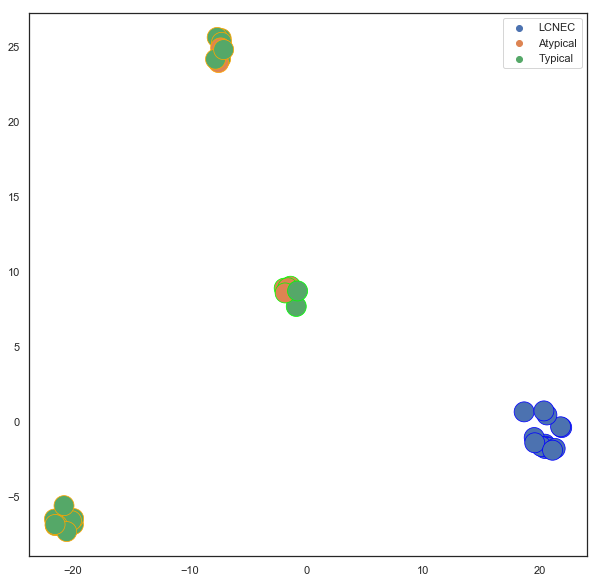

In [133]:
sns.set(style='white', rc={'figure.figsize':(10,10)})
sns.scatterplot(test_sup_embedding[:, 0], test_sup_embedding[:, 1],  hue=y_test, edgecolor=edges_col_2 ,s=400)
plt.show()

In [134]:
kmean_acc_3 , kmean_lab_3 =label_pred(y_test, kmeans_pred_3 )

pred_label  0   1   2
y_test               
Atypical    6   0   0
LCNEC       0  14   0
Typical     8   0  10
acc_score [0.7894736842105263, 0.15789473684210525, 0.2631578947368421, 0.21052631578947367, 0.0, 0.5789473684210527]
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}


In [135]:
edges_col_3 = []
for i in kmean_lab_3:
    if i == "Typical":
        edges_col_3.append("orange")
    elif i == "LCNEC":
        edges_col_3.append("blue")
    elif i == "Atypical":
        edges_col_3.append("lime")
    else :
        print("warning")

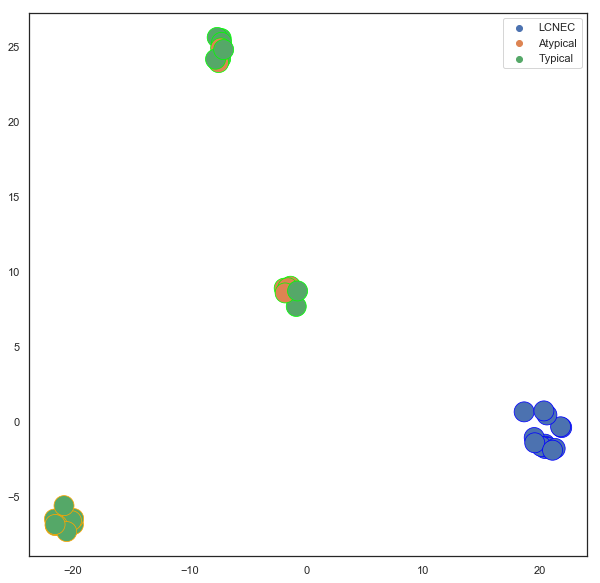

In [136]:
sns.set(style='white', rc={'figure.figsize':(10,10)})
sns.scatterplot(test_sup_embedding[:, 0], test_sup_embedding[:, 1],  hue=y_test, edgecolor=edges_col_3 ,s=400)
plt.show()

In [137]:
print("Knn accurancy  : ",knn_3.score(trans_sup.transform(X_test), y_test) )
print("SVC accurancy  : ",svc_3.score(trans_sup.transform(X_test), y_test) )
print("Kmeans accurancy  : ",kmean_acc_3 )

Knn accurancy  :  0.8947368421052632
SVC accurancy  :  0.8947368421052632
Kmeans accurancy  :  0.7894736842105263


In [138]:
print("Knn silhouette score  : ",silhouette_score(trans_sup.transform(X_test), knn_pred_3) )
print("Svc silhouette score  : ",silhouette_score(trans_sup.transform(X_test), svc_pred_3) )
print("Kmeans silhouette score  : ",silhouette_score(trans_sup.transform(X_test), kmeans_pred_3) )

Knn silhouette score  :  0.54709893
Svc silhouette score  :  0.54709893
Kmeans silhouette score  :  0.84736896


# Min dist

In [139]:
min_dist_test = [0,0.5,1]

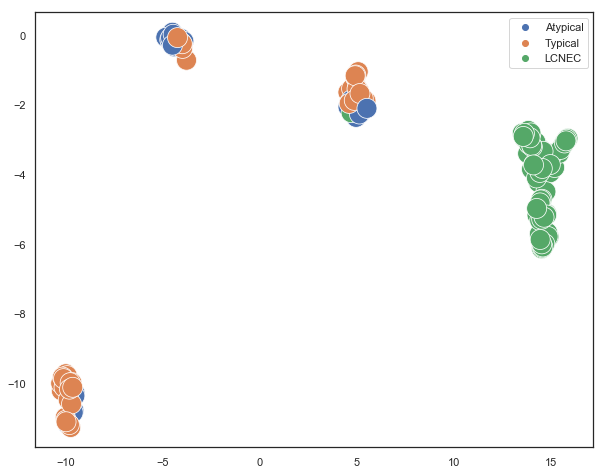

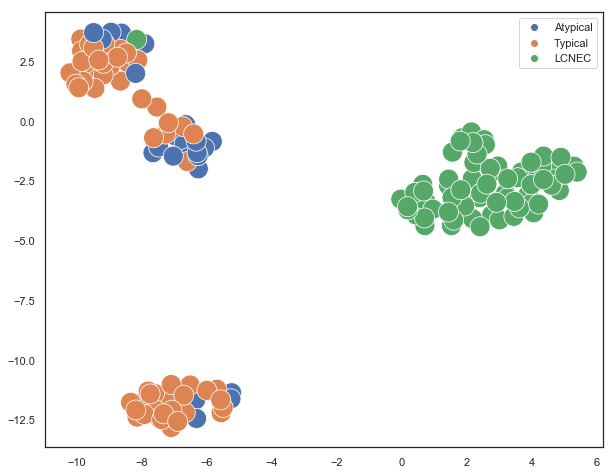

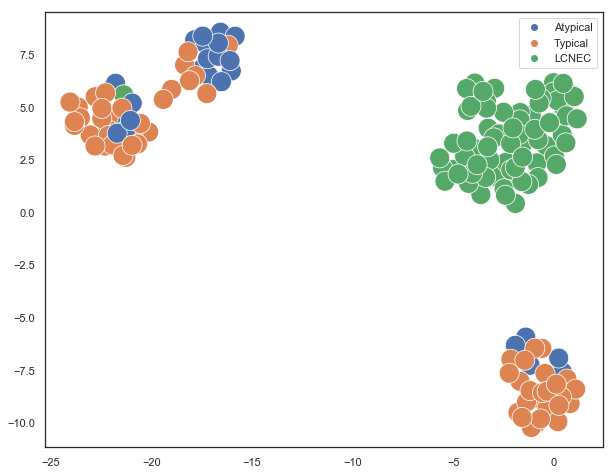

In [140]:
sns.set(style='white', rc={'figure.figsize':(10,8)})
lv_50_data = data_lv_50_type3.iloc[:,1:6398]
#lv_50_type = data_lv_50_type3.iloc[:,6399]
standard_embedding_0 = umap.UMAP(min_dist=0).fit_transform(lv_50_data)
sns.scatterplot(x=standard_embedding_0[:, 0], y=standard_embedding_0[:, 1],  hue=lv_50_type, s=400)
plt.show()
sns.set(style='white', rc={'figure.figsize':(10,8)})
lv_50_data = data_lv_50_type3.iloc[:,1:6398]
#lv_50_type = data_lv_50_type3.iloc[:,6399]
standard_embedding_05 = umap.UMAP(min_dist=0.5).fit_transform(lv_50_data)
sns.scatterplot(x=standard_embedding_05[:, 0], y=standard_embedding_05[:, 1],  hue=lv_50_type, s=400)
plt.show()
sns.set(style='white', rc={'figure.figsize':(10,8)})
lv_50_data = data_lv_50_type3.iloc[:,1:6398]
#lv_50_type = data_lv_50_type3.iloc[:,6399]
standard_embedding_1 = umap.UMAP(min_dist=1).fit_transform(lv_50_data)
sns.scatterplot(x=standard_embedding_1[:, 0], y=standard_embedding_1[:, 1],  hue=lv_50_type, s=400)
plt.show()


**The default value for min_dist (as used above) is 0.1. We will look at a range of values from 0.0 through to 0.99.**

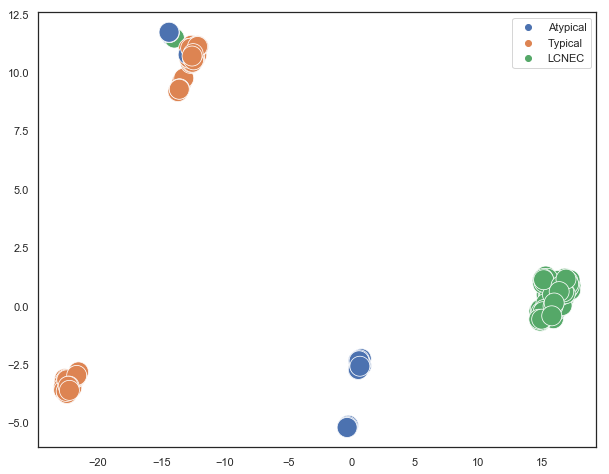

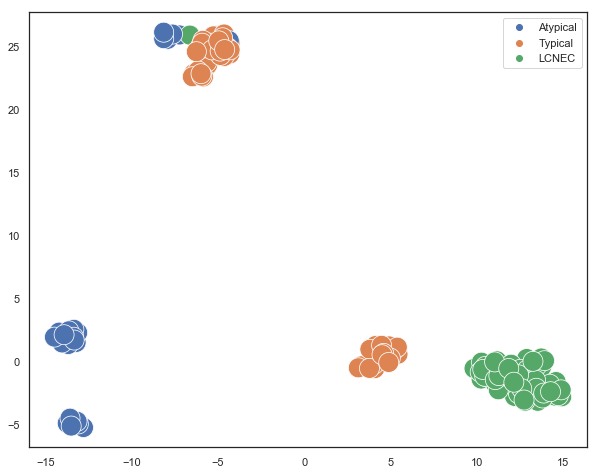

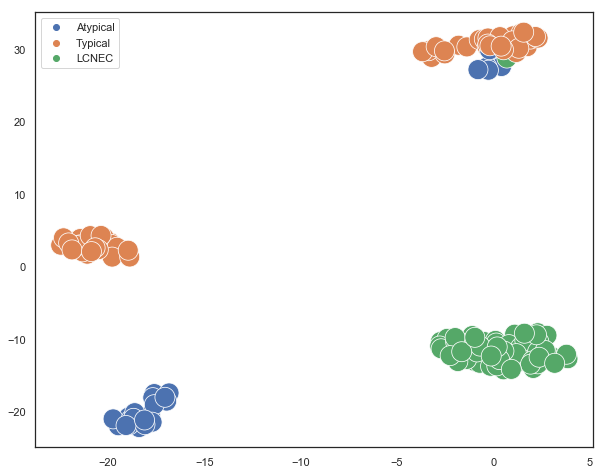

In [141]:
embedding_MD_0 = umap.UMAP(min_dist=0).fit_transform(lv_50_data, y=typeN)
sns.set(style='white', rc={'figure.figsize':(10,8)})
sns.scatterplot(x=embedding_MD_0[:, 0], y=embedding_MD_0[:, 1],  hue=lv_50_type, s=400)
plt.show()

embedding_MD_05 = umap.UMAP(min_dist=0.5).fit_transform(lv_50_data, y=typeN)
sns.set(style='white', rc={'figure.figsize':(10,8)})
sns.scatterplot(x=embedding_MD_05[:, 0], y=embedding_MD_05[:, 1],  hue=lv_50_type, s=400)
plt.show()

embedding_MD_1 = umap.UMAP(min_dist=1).fit_transform(lv_50_data, y=typeN)
sns.set(style='white', rc={'figure.figsize':(10,8)})
sns.scatterplot(x=embedding_MD_1[:, 0], y=embedding_MD_1[:, 1],  hue=lv_50_type, s=400)
plt.show()

## Neighborhood preservation

### Distance

In [142]:
standard_embedding_0_df=  pd.DataFrame(data_lv_50_type3.iloc[:,0])
standard_embedding_0_df['X'] = standard_embedding_0[:,0]
standard_embedding_0_df['Y'] = standard_embedding_0[:,1]

standard_embedding_05_df=  pd.DataFrame(data_lv_50_type3.iloc[:,0])
standard_embedding_05_df['X'] = standard_embedding_05[:,0]
standard_embedding_05_df['Y'] = standard_embedding_05[:,1]

standard_embedding_1_df=  pd.DataFrame(data_lv_50_type3.iloc[:,0])
standard_embedding_1_df['X'] = standard_embedding_1[:,0]
standard_embedding_1_df['Y'] = standard_embedding_1[:,1]

d_umap_md_0 =  Neighborhood.distance_matrix(standard_embedding_0_df)
d_umap_md_05 =  Neighborhood.distance_matrix(standard_embedding_05_df)
d_umap_md_1 =  Neighborhood.distance_matrix(standard_embedding_1_df)


d_mofa_expr = Neighborhood.distance_matrix(coords_mofa_expr_lnen)

Dist_pulmonary =  pd.read_csv("Distance_pulmo.txt", sep="\t") # "real distances" in Rn

In [143]:
coords_mofa_expr_lnen.head()
Sample_ID_df =pd.DataFrame(data_lv_50_type3["Sample_ID"] )
coords_mofa_expr_lnen_v2 = pd.merge(coords_mofa_expr_lnen, Sample_ID_df, on='Sample_ID', how='inner')
coords_mofa_expr_lnen = coords_mofa_expr_lnen_v2

## Writing

In [144]:
standard_embedding_0_df.to_csv(path_or_buf='umap_md_0_coord.txt', sep='\t')
standard_embedding_05_df.to_csv(path_or_buf='umap_md_05_coord.txt', sep='\t')
standard_embedding_1_df.to_csv(path_or_buf='umap_md_1_coord.txt', sep='\t')

# CP

In [ ]:
# cp0 = Neighborhood.centrality_preservation(d_umap_md_0 ,  Dist_pulmonary , range(1,len(standard_embedding_0[:,0]),10),"CP_pulmo_R_UMAP_MD0")
#cp05 = Neighborhood.centrality_preservation(d_umap_md_05 ,  Dist_pulmonary , range(1,len(standard_embedding_05[:,0]),10),"CP_pulmo_R_UMAP_MD05")
#cp1 = Neighborhood.centrality_preservation(d_umap_md_1 ,  Dist_pulmonary , range(1,len(standard_embedding_1[:,0]),10),"CP_pulmo_R_UMAP_MD1")


![CPMinDist](cp_min_dist_v2.png)

# Seq Set

In [749]:
Neighborhood.main_f(d_umap_md_0 , Dist_pulmonary, d_supervised.shape[0] , "set_diff_pulmo_R_UMAP_MD0" , "seq_diff_pulmo_R_UMAP_MD0" , True )
Neighborhood.main_f(d_umap_md_05, Dist_pulmonary, d_supervised.shape[0] , "set_diff_pulmo_R_UMAP_MD05" , "seq_diff_pulmo_R_UMAP_MD05" , True )
Neighborhood.main_f(d_umap_md_1, Dist_pulmonary, d_mofa_expr.shape[0] , "set_diff_pulmo_R_UMAP_MD1" , "seq_diff_pulmo_R_UMAP_MD1" , True )

dist1.shape (152, 152)
dist2.shape (152, 152)
k 152
df1.shape[0] 152
A file named set_diff.txt have been created
dist1.shape (152, 152)
dist2.shape (152, 152)
k 152
df1.shape[0] 152
A file named set_diff.txt have been created
dist1.shape (152, 152)
dist2.shape (152, 152)
k 152
df1.shape[0] 152
A file named set_diff.txt have been created


In [753]:
Neighborhood.main_f(d_umap_md_1, Dist_pulmonary, d_mofa_expr.shape[0] , "set_diff_pulmo_R_UMAP_MD1" , "seq_diff_pulmo_R_UMAP_MD1" , True )

dist1.shape (152, 152)
dist2.shape (152, 152)
k 152
df1.shape[0] 152
A file named set_diff.txt have been created


![set_diff_min_dist_v2](set_diff_min_dist_v2.png)

![seq_diff_v2](seq_diff_v2.png)
![seq_diff_min_dist_log](seq_diff_min_dist_log.png)

## Clustering

In [843]:
min_dist_test = [0,0.5,1,2.5]
knn_acc_no_prepro =[]
svc_acc_no_prepro =[]
kmeans_acc_no_prepro =[]
for j  in range(5):
    CV = train_test_split(lv_50_data,lv_50_type,lv_50_type )
    X_train = CV[0]
    X_test = CV[1]
    y_train = CV[2]
    y_test = CV[3]
        
    knn_1 = KNeighborsClassifier().fit(X_train, y_train)
    svc_1 = SVC().fit(X_train, y_train)
    kmeans_1 = KMeans(n_clusters=3).fit(X_train)
    knn_1.fit(X_train, y_train)
    pred_knn_1 = knn.predict(X_test)
    pred_kmeans_1 = kmeans.predict(X_test)
    kmean_acc_1 , kmean_lab_1 =label_pred(y_test, pred_kmeans_1 )
    
    
    print("Knn accurancy  : ",knn_1.score(X_test, y_test))
    print("SVC accurancy  : ",svc_1.score(X_test, y_test))
    print("Kmeans accurancy  : ", kmean_acc_1)
    knn_acc_no_prepro.append(knn_1.score(X_test, y_test))  
    svc_acc_no_prepro.append(svc_1.score(X_test, y_test))
    kmeans_acc_no_prepro.append(kmean_acc_1)
        
        

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Knn accurancy  :  0.8947368421052632
SVC accurancy  :  0.868421052631579
Kmeans accurancy  :  0.8157894736842105


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Knn accurancy  :  0.8421052631578947
SVC accurancy  :  0.6578947368421053
Kmeans accurancy  :  0.7105263157894737


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Knn accurancy  :  0.8947368421052632
SVC accurancy  :  0.7368421052631579
Kmeans accurancy  :  0.7368421052631579


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Knn accurancy  :  0.7894736842105263
SVC accurancy  :  0.7631578947368421
Kmeans accurancy  :  0.7631578947368421


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Knn accurancy  :  0.9210526315789473
SVC accurancy  :  0.6052631578947368
Kmeans accurancy  :  0.7631578947368421


In [852]:
list_clustering=["knn_acc"]*5 + ["svc_acc"]*5 + ["kmeans_acc"]*5
Acc_val = knn_acc_no_prepro + svc_acc_no_prepro + kmeans_acc_no_prepro

In [853]:
clustering_res_no_preprocessing = pd.DataFrame() 
clustering_res_no_preprocessing['clustering_method'] = list_clustering
clustering_res_no_preprocessing['Acc_val'] = Acc_val
clustering_res_no_preprocessing.shape

(15, 2)

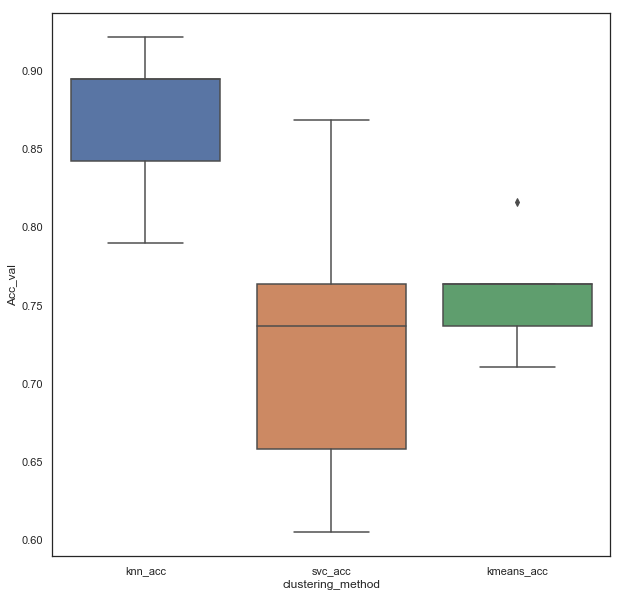

In [854]:
sns.boxplot(x="clustering_method", y="Acc_val", data=clustering_res_no_preprocessing)

In [842]:
min_dist_test = [0,0.5,1]
min_dist = []
knn_acc = []
kmeans_acc = []
svc_acc = []

knn_silh = []
kmeans_silh = []
svc_silh = []



for i in min_dist_test :
    print('\n')
    print('i', i)
    for j  in range(5):
        CV = train_test_split(lv_50_data,lv_50_type,lv_50_type )
        X_train = CV[0]
        X_test = CV[1]
        y_train = CV[2]
        y_test = CV[3]
        
        trans = umap.UMAP(min_dist = i).fit(X_train)
        svc_2 = SVC().fit(trans.embedding_, y_train)
        knn_2 = KNeighborsClassifier().fit(trans.embedding_, y_train)
        kmeans_2 = KMeans(n_clusters=3).fit(trans.embedding_, y_train)
        
        test_embedding = trans.transform(X_test)
        svc_pred_2= svc_2.predict(test_embedding)
        knn_pred_2 = knn_2.predict(test_embedding)
        kmeans_pred_2 = kmeans_2.predict(test_embedding)
        
        kmean_acc_2 , kmean_lab_2 =label_pred(y_test, kmeans_pred_2 )
        
        print("Knn accurancy  : ",knn_2.score(trans.transform(X_test), y_test) )
        print("SVC accurancy  : ",svc_2.score(trans.transform(X_test), y_test) )
        print("Kmeans accurancy  : ",kmean_acc_2 )
        
        print("Knn silhouette score  : ",silhouette_score(trans_sup.transform(X_test), knn_pred_2) )
        print("Svc silhouette score  : ",silhouette_score(trans_sup.transform(X_test), svc_pred_2) )
        print("Kmeans silhouette score  : ",silhouette_score(trans_sup.transform(X_test), kmeans_pred_2) )
        
        min_dist.append(i)
        knn_acc.append(knn_2.score(trans.transform(X_test), y_test))
        svc_acc.append(svc_2.score(trans.transform(X_test), y_test))
        kmeans_acc.append(kmean_acc_2)
        
        knn_silh.append(silhouette_score(trans_sup.transform(X_test), knn_pred_2))
        svc_silh.append(silhouette_score(trans_sup.transform(X_test), svc_pred_2))
        kmeans_silh.append(silhouette_score(trans_sup.transform(X_test), kmeans_pred_2))
        
        



i 0


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Knn accurancy  :  0.868421052631579
SVC accurancy  :  0.9473684210526315
Kmeans accurancy  :  0.7631578947368421
Knn silhouette score  :  0.39382055
Svc silhouette score  :  0.51883256
Kmeans silhouette score  :  0.77921224


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Knn accurancy  :  0.868421052631579
SVC accurancy  :  0.8947368421052632
Kmeans accurancy  :  0.9210526315789473
Knn silhouette score  :  0.6001744
Svc silhouette score  :  0.62654847
Kmeans silhouette score  :  0.64345175


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Knn accurancy  :  0.7631578947368421
SVC accurancy  :  0.8157894736842105
Kmeans accurancy  :  0.7631578947368421
Knn silhouette score  :  0.42339993
Svc silhouette score  :  0.47677797
Kmeans silhouette score  :  0.68511564


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Knn accurancy  :  0.8947368421052632
SVC accurancy  :  0.8947368421052632
Kmeans accurancy  :  0.8157894736842105
Knn silhouette score  :  0.56659055
Svc silhouette score  :  0.56659055
Kmeans silhouette score  :  0.6514714


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Knn accurancy  :  0.8421052631578947
SVC accurancy  :  0.8421052631578947
Kmeans accurancy  :  0.7894736842105263
Knn silhouette score  :  0.48096824
Svc silhouette score  :  0.48096824
Kmeans silhouette score  :  0.8401268


i 0.5


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Knn accurancy  :  0.9210526315789473
SVC accurancy  :  0.8421052631578947
Kmeans accurancy  :  0.7894736842105263
Knn silhouette score  :  0.5284694
Svc silhouette score  :  0.48623028
Kmeans silhouette score  :  0.8066394


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Knn accurancy  :  0.8421052631578947
SVC accurancy  :  0.8421052631578947
Kmeans accurancy  :  0.7894736842105263
Knn silhouette score  :  0.5322597
Svc silhouette score  :  0.5322597
Kmeans silhouette score  :  0.59604144


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Knn accurancy  :  0.8421052631578947
SVC accurancy  :  0.8947368421052632
Kmeans accurancy  :  0.8157894736842105
Knn silhouette score  :  0.51653254
Svc silhouette score  :  0.5192339
Kmeans silhouette score  :  0.5770461


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Knn accurancy  :  0.8157894736842105
SVC accurancy  :  0.8157894736842105
Kmeans accurancy  :  0.6842105263157895
Knn silhouette score  :  0.3996525
Svc silhouette score  :  0.3996525
Kmeans silhouette score  :  0.7809844


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Knn accurancy  :  0.8947368421052632
SVC accurancy  :  0.868421052631579
Kmeans accurancy  :  0.7894736842105263
Knn silhouette score  :  0.5393406
Svc silhouette score  :  0.66351146
Kmeans silhouette score  :  0.6268521


i 1


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Knn accurancy  :  0.7105263157894737
SVC accurancy  :  0.7105263157894737
Kmeans accurancy  :  0.7894736842105263
Knn silhouette score  :  0.26692045
Svc silhouette score  :  0.26692045
Kmeans silhouette score  :  0.7927367


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Knn accurancy  :  0.8157894736842105
SVC accurancy  :  0.8421052631578947
Kmeans accurancy  :  0.7631578947368421
Knn silhouette score  :  0.43172193
Svc silhouette score  :  0.35519183
Kmeans silhouette score  :  0.6967153


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Knn accurancy  :  0.7894736842105263
SVC accurancy  :  0.7368421052631579
Kmeans accurancy  :  0.7368421052631579
Knn silhouette score  :  0.43994367
Svc silhouette score  :  0.19866511
Kmeans silhouette score  :  0.74728465


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Knn accurancy  :  0.868421052631579
SVC accurancy  :  0.8421052631578947
Kmeans accurancy  :  0.7368421052631579
Knn silhouette score  :  0.43562517
Svc silhouette score  :  0.39594388
Kmeans silhouette score  :  0.7835209


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Knn accurancy  :  0.9210526315789473
SVC accurancy  :  0.8947368421052632
Kmeans accurancy  :  0.7631578947368421
Knn silhouette score  :  0.567857
Svc silhouette score  :  0.6383603
Kmeans silhouette score  :  0.66935825


In [856]:
len(knn_acc)

15

In [871]:
list_clustering=["knn_acc"]*len(knn_acc) + ["svc_acc"]*len(knn_acc) + ["kmeans_acc"]*len(knn_acc)
Acc_val = knn_acc + svc_acc + kmeans_acc
Sihl_val = knn_silh + svc_silh+ kmeans_silh
Min_dist_val = min_dist + min_dist + min_dist

45
15
45
[0, 0, 0, 0, 0, 0.5, 0.5, 0.5, 0.5, 0.5, 1, 1, 1, 1, 1]


In [872]:
clustering_res = pd.DataFrame() 
clustering_res['clustering_method'] = list_clustering
clustering_res['Acc_val'] = Acc_val
clustering_res['Silh_val'] = Sihl_val
clustering_res['min_dist'] = Min_dist_val
clustering_res.shape
clustering_res.head

<bound method NDFrame.head of    clustering_method   Acc_val  Silh_val  min_dist
0            knn_acc  0.868421  0.393821       0.0
1            knn_acc  0.868421  0.600174       0.0
2            knn_acc  0.763158  0.423400       0.0
3            knn_acc  0.894737  0.566591       0.0
4            knn_acc  0.842105  0.480968       0.0
5            knn_acc  0.921053  0.528469       0.5
6            knn_acc  0.842105  0.532260       0.5
7            knn_acc  0.842105  0.516533       0.5
8            knn_acc  0.815789  0.399653       0.5
9            knn_acc  0.894737  0.539341       0.5
10           knn_acc  0.710526  0.266920       1.0
11           knn_acc  0.815789  0.431722       1.0
12           knn_acc  0.789474  0.439944       1.0
13           knn_acc  0.868421  0.435625       1.0
14           knn_acc  0.921053  0.567857       1.0
15           svc_acc  0.947368  0.518833       0.0
16           svc_acc  0.894737  0.626548       0.0
17           svc_acc  0.815789  0.476778       0.0
1

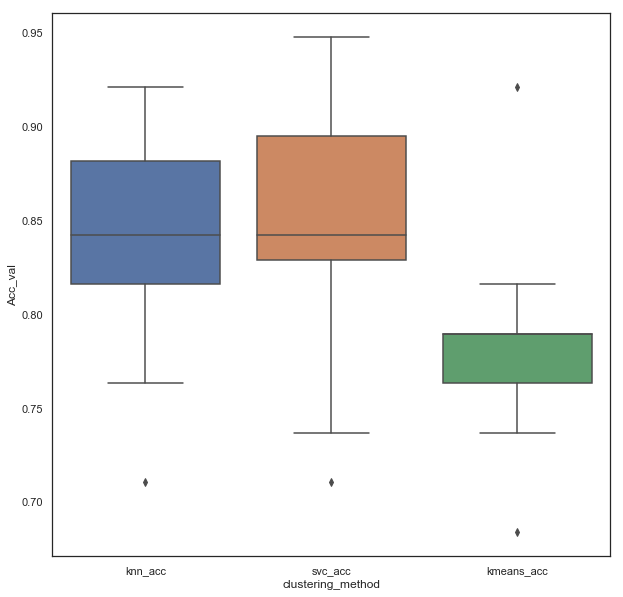

In [873]:
sns.boxplot(x="clustering_method", y="Acc_val", data=clustering_res)


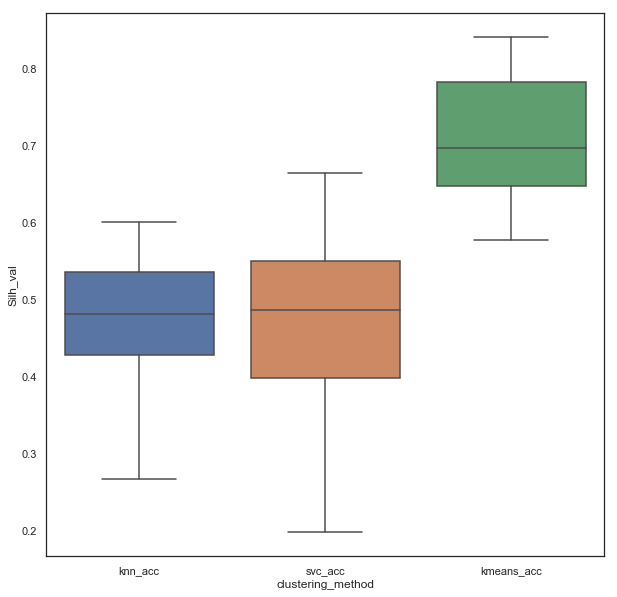

In [874]:
sns.boxplot(x="clustering_method", y="Silh_val", data=clustering_res)

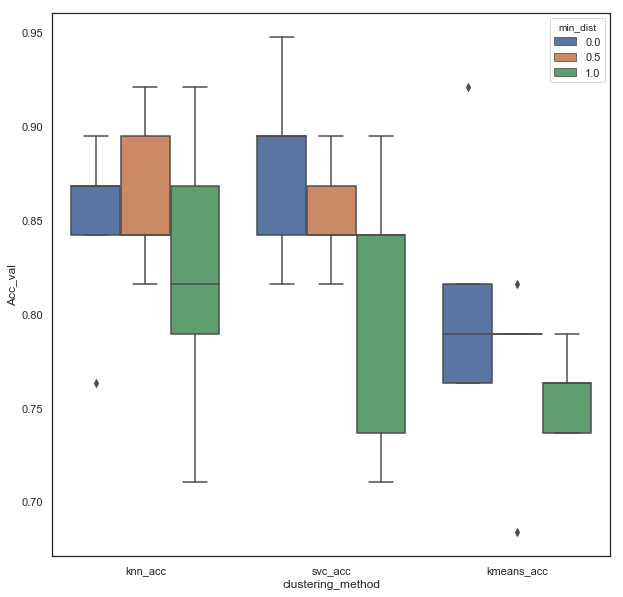

In [875]:
sns.boxplot(x="clustering_method", y="Acc_val", hue="min_dist", data=clustering_res)

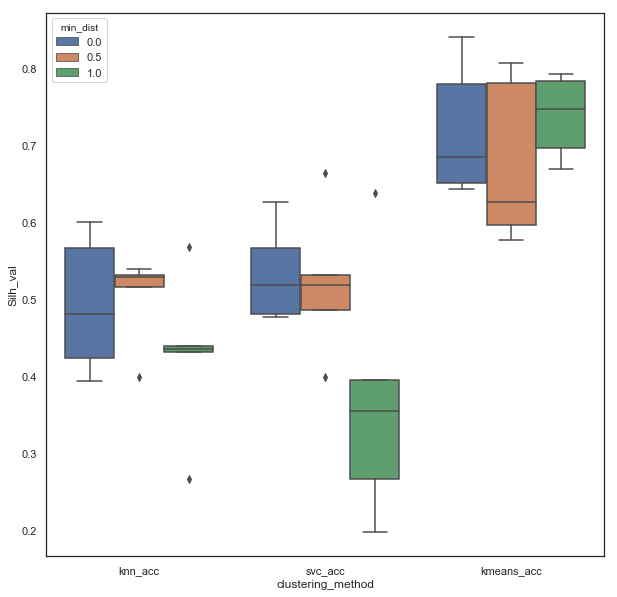

In [876]:
sns.boxplot(x="clustering_method", y="Silh_val", hue="min_dist", data=clustering_res)

# Min dist + N_neighbors

In [19]:
min_dist_test = [0,0.5,1]
n_neighbors_test  = [2, 10,50,100 ]

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 25 separate connected components using meta-embedding (experimental)
  n_components
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


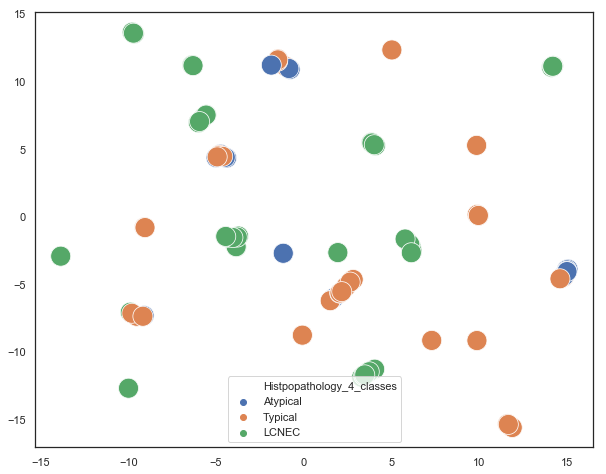

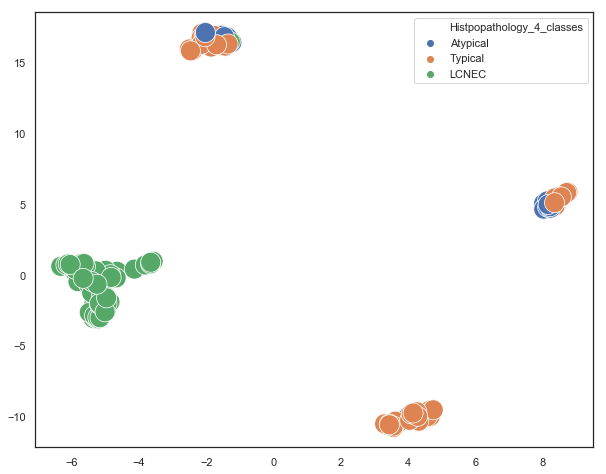

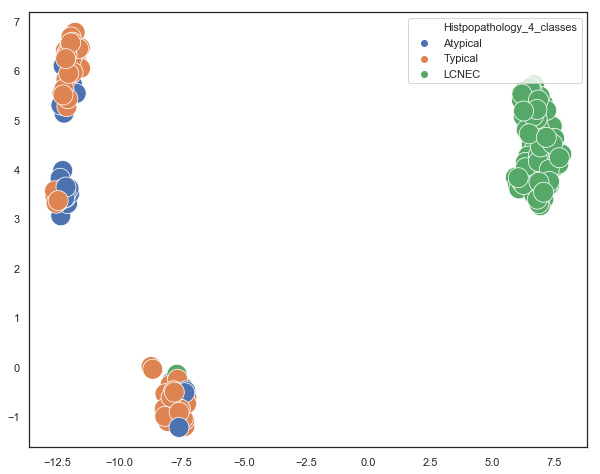

In [20]:
sns.set(style='white', rc={'figure.figsize':(10,8)})
lv_50_data = data_lv_50_type3.iloc[:,1:6398]
#lv_50_type = data_lv_50_type3.iloc[:,6399]
standard_embedding_0 = umap.UMAP(min_dist=0, n_neighbors = 2).fit_transform(lv_50_data)
sns.scatterplot(x=standard_embedding_0[:, 0], y=standard_embedding_0[:, 1],  hue=lv_50_type, s=400)
plt.show()
sns.set(style='white', rc={'figure.figsize':(10,8)})
lv_50_data = data_lv_50_type3.iloc[:,1:6398]
#lv_50_type = data_lv_50_type3.iloc[:,6399]
standard_embedding_05 = umap.UMAP(min_dist=0,  n_neighbors = 10).fit_transform(lv_50_data)
sns.scatterplot(x=standard_embedding_05[:, 0], y=standard_embedding_05[:, 1],  hue=lv_50_type, s=400)
plt.show()
sns.set(style='white', rc={'figure.figsize':(10,8)})
lv_50_data = data_lv_50_type3.iloc[:,1:6398]
#lv_50_type = data_lv_50_type3.iloc[:,6399]
standard_embedding_1 = umap.UMAP(min_dist=0,  n_neighbors = 50).fit_transform(lv_50_data)
sns.scatterplot(x=standard_embedding_1[:, 0], y=standard_embedding_1[:, 1],  hue=lv_50_type, s=400)
plt.show()

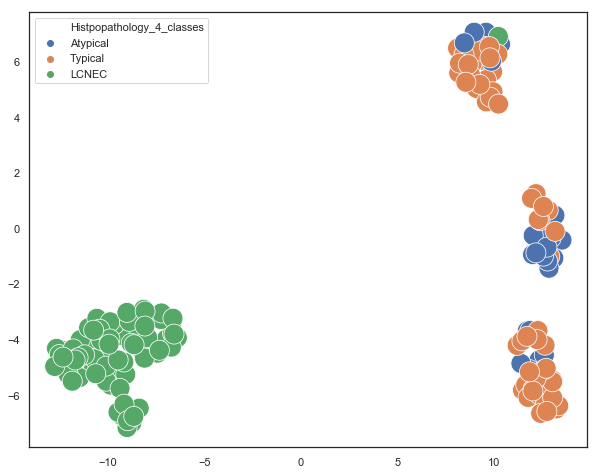

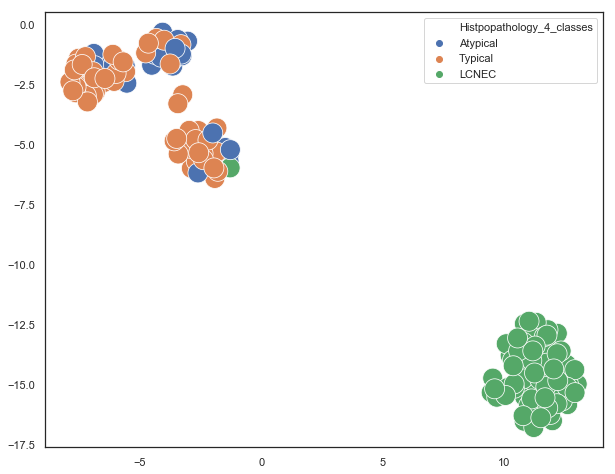

In [21]:
lv_50_data = data_lv_50_type3.iloc[:,1:6398]

sns.set(style='white', rc={'figure.figsize':(10,8)})
lv_50_data = data_lv_50_type3.iloc[:,1:6398]
#lv_50_type = data_lv_50_type3.iloc[:,6399]
standard_embedding_05 = umap.UMAP(min_dist=0.5,  n_neighbors = 10).fit_transform(lv_50_data)
sns.scatterplot(x=standard_embedding_05[:, 0], y=standard_embedding_05[:, 1],  hue=lv_50_type, s=400)
plt.show()
sns.set(style='white', rc={'figure.figsize':(10,8)})
lv_50_data = data_lv_50_type3.iloc[:,1:6398]
#lv_50_type = data_lv_50_type3.iloc[:,6399]
standard_embedding_1 = umap.UMAP(min_dist=0.5,  n_neighbors = 50).fit_transform(lv_50_data)
sns.scatterplot(x=standard_embedding_1[:, 0], y=standard_embedding_1[:, 1],  hue=lv_50_type, s=400)
plt.show()

## Neighborhood preservation

### Distance

In [22]:

embedding_MD_0_NN2 = umap.UMAP(min_dist=0, n_neighbors=2).fit_transform(lv_50_data, y=typeN)
embedding_MD_0_NN10 = umap.UMAP(min_dist=0, n_neighbors=10).fit_transform(lv_50_data, y=typeN)
embedding_MD_0_NN50 = umap.UMAP(min_dist=0, n_neighbors=50).fit_transform(lv_50_data, y=typeN)
embedding_MD_0_NN100 = umap.UMAP(min_dist=0, n_neighbors=100).fit_transform(lv_50_data, y=typeN)

embedding_MD_05_NN2 = umap.UMAP(min_dist=0.5, n_neighbors=2).fit_transform(lv_50_data, y=typeN)
embedding_MD_05_NN10 = umap.UMAP(min_dist=0.5, n_neighbors=10).fit_transform(lv_50_data, y=typeN)
embedding_MD_05_NN50 = umap.UMAP(min_dist=0.5, n_neighbors=50).fit_transform(lv_50_data, y=typeN)
embedding_MD_05_NN100 = umap.UMAP(min_dist=0.5, n_neighbors=100).fit_transform(lv_50_data, y=typeN)

embedding_MD_1_NN2 = umap.UMAP(min_dist=1, n_neighbors=2).fit_transform(lv_50_data, y=typeN)
embedding_MD_1_NN10 = umap.UMAP(min_dist=1, n_neighbors=10).fit_transform(lv_50_data, y=typeN)
embedding_MD_1_NN50 = umap.UMAP(min_dist=1, n_neighbors=50).fit_transform(lv_50_data, y=typeN)
embedding_MD_1_NN100 = umap.UMAP(min_dist=1, n_neighbors=100).fit_transform(lv_50_data, y=typeN)

###
embedding_MD_0_NN2_df=  pd.DataFrame(data_lv_50_type3.iloc[:,0])
embedding_MD_0_NN2_df['X'] = embedding_MD_0_NN2[:,0]
embedding_MD_0_NN2_df['Y'] = embedding_MD_0_NN2[:,1]

embedding_MD_0_NN10_df=  pd.DataFrame(data_lv_50_type3.iloc[:,0])
embedding_MD_0_NN10_df['X'] = embedding_MD_0_NN10[:,0]
embedding_MD_0_NN10_df['Y'] = embedding_MD_0_NN10[:,1]

embedding_MD_0_NN50_df=  pd.DataFrame(data_lv_50_type3.iloc[:,0])
embedding_MD_0_NN50_df['X'] = embedding_MD_0_NN50[:,0]
embedding_MD_0_NN50_df['Y'] = embedding_MD_0_NN50[:,1]

embedding_MD_0_NN100_df=  pd.DataFrame(data_lv_50_type3.iloc[:,0])
embedding_MD_0_NN100_df['X'] = embedding_MD_0_NN100[:,0]
embedding_MD_0_NN100_df['Y'] = embedding_MD_0_NN100[:,1]


d_umap_md_0_nn2 =  Neighborhood.distance_matrix(embedding_MD_0_NN2_df)
d_umap_md_0_nn10 =  Neighborhood.distance_matrix(embedding_MD_0_NN10_df)
d_umap_md_0_nn50 =  Neighborhood.distance_matrix(embedding_MD_0_NN50_df)
d_umap_md_0_nn100 =  Neighborhood.distance_matrix(embedding_MD_0_NN100_df)


##


embedding_MD_05_NN2_df=  pd.DataFrame(data_lv_50_type3.iloc[:,0])
embedding_MD_05_NN2_df['X'] = embedding_MD_05_NN2[:,0]
embedding_MD_05_NN2_df['Y'] = embedding_MD_05_NN2[:,1]

embedding_MD_05_NN10_df=  pd.DataFrame(data_lv_50_type3.iloc[:,0])
embedding_MD_05_NN10_df['X'] = embedding_MD_05_NN10[:,0]
embedding_MD_05_NN10_df['Y'] = embedding_MD_05_NN10[:,1]

embedding_MD_05_NN50_df=  pd.DataFrame(data_lv_50_type3.iloc[:,0])
embedding_MD_05_NN50_df['X'] = embedding_MD_05_NN50[:,0]
embedding_MD_05_NN50_df['Y'] = embedding_MD_05_NN50[:,1]

embedding_MD_05_NN100_df=  pd.DataFrame(data_lv_50_type3.iloc[:,0])
embedding_MD_05_NN100_df['X'] = embedding_MD_05_NN100[:,0]
embedding_MD_05_NN100_df['Y'] = embedding_MD_05_NN100[:,1]

d_umap_md_05_nn2 =  Neighborhood.distance_matrix(embedding_MD_05_NN2_df)
d_umap_md_05_nn10 =  Neighborhood.distance_matrix(embedding_MD_05_NN10_df)
d_umap_md_05_nn50 =  Neighborhood.distance_matrix(embedding_MD_05_NN50_df)
d_umap_md_05_nn100 =  Neighborhood.distance_matrix(embedding_MD_05_NN100_df)

####

embedding_MD_1_NN2_df=  pd.DataFrame(data_lv_50_type3.iloc[:,0])
embedding_MD_1_NN2_df['X'] = embedding_MD_1_NN2[:,0]
embedding_MD_1_NN2_df['Y'] = embedding_MD_1_NN2[:,1]

embedding_MD_1_NN10_df=  pd.DataFrame(data_lv_50_type3.iloc[:,0])
embedding_MD_1_NN10_df['X'] = embedding_MD_1_NN10[:,0]
embedding_MD_1_NN10_df['Y'] = embedding_MD_1_NN10[:,1]

embedding_MD_1_NN50_df=  pd.DataFrame(data_lv_50_type3.iloc[:,0])
embedding_MD_1_NN50_df['X'] = embedding_MD_1_NN50[:,0]
embedding_MD_1_NN50_df['Y'] = embedding_MD_1_NN50[:,1]

embedding_MD_1_NN100_df=  pd.DataFrame(data_lv_50_type3.iloc[:,0])
embedding_MD_1_NN100_df['X'] = embedding_MD_1_NN100[:,0]
embedding_MD_1_NN100_df['Y'] = embedding_MD_1_NN100[:,1]

d_umap_md_1_nn2 =  Neighborhood.distance_matrix(embedding_MD_1_NN2_df)
d_umap_md_1_nn10 =  Neighborhood.distance_matrix(embedding_MD_1_NN10_df)
d_umap_md_1_nn50 =  Neighborhood.distance_matrix(embedding_MD_1_NN50_df)
d_umap_md_1_nn100 =  Neighborhood.distance_matrix(embedding_MD_1_NN100_df)

##

d_mofa_expr = Neighborhood.distance_matrix(coords_mofa_expr_lnen)

Dist_pulmonary =  pd.read_csv("Distance_pulmo.txt", sep="\t") # "real distances" in Rn



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 25 separate connected components using meta-embedding (experimental)
  n_components
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/umap/spectral.py:182: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: 

## Writing

In [883]:
embedding_MD_0_NN2_df.to_csv(path_or_buf='umap_MD_0_NN2_coords.txt', sep='\t')
embedding_MD_0_NN10_df.to_csv(path_or_buf='umap_MD_0_NN10_coords.txt', sep='\t')
embedding_MD_0_NN50_df.to_csv(path_or_buf='umap_MD_0_NN50_coords.txt', sep='\t')
embedding_MD_0_NN100_df.to_csv(path_or_buf='umap_MD_0_NN100_coords.txt', sep='\t')


embedding_MD_05_NN2_df.to_csv(path_or_buf='umap_MD_05_NN2_coords.txt', sep='\t')
embedding_MD_05_NN10_df.to_csv(path_or_buf='umap_MD_05_NN10_coords.txt', sep='\t')
embedding_MD_05_NN50_df.to_csv(path_or_buf='umap_MD_05_NN50_coords.txt', sep='\t')
embedding_MD_05_NN100_df.to_csv(path_or_buf='umap_MD_05_NN100_coords.txt', sep='\t')


embedding_MD_1_NN2_df.to_csv(path_or_buf='umap_MD_1_NN2_coords.txt', sep='\t')
embedding_MD_1_NN10_df.to_csv(path_or_buf='umap_MD_1_NN10_coords.txt', sep='\t')
embedding_MD_1_NN50_df.to_csv(path_or_buf='umap_MD_1_NN50_coords.txt', sep='\t')
embedding_MD_1_NN100_df.to_csv(path_or_buf='umap_MD_1_NN100_coords.txt', sep='\t')


# CP

In [884]:
#cp_MD_0_NN2 = Neighborhood.centrality_preservation(d_umap_md_0_nn2 ,  Dist_pulmonary , range(1,len(standard_embedding_0[:,0]),20),"CP_pulmo_R_UMAP_MD0_NN2")
cp_MD_0_NN10 = Neighborhood.centrality_preservation(d_umap_md_0_nn10 ,  Dist_pulmonary , range(1,len(standard_embedding_0[:,0]),20),"CP_pulmo_R_UMAP_MD0_NN10")
cp_MD_0_NN50 = Neighborhood.centrality_preservation(d_umap_md_0_nn50 ,  Dist_pulmonary , range(1,len(standard_embedding_0[:,0]),20),"CP_pulmo_R_UMAP_MD0_NN50")
cp_MD_0_NN100 = Neighborhood.centrality_preservation(d_umap_md_0_nn100 ,  Dist_pulmonary , range(1,len(standard_embedding_0[:,0]),20),"CP_pulmo_R_UMAP_MD0_NN100")

cp_MD_05_NN10 = Neighborhood.centrality_preservation(d_umap_md_05_nn10 ,  Dist_pulmonary , range(1,len(standard_embedding_0[:,0]),20),"CP_pulmo_R_UMAP_MD05_NN10")
cp_MD_05_NN50 = Neighborhood.centrality_preservation(d_umap_md_05_nn50 ,  Dist_pulmonary , range(1,len(standard_embedding_0[:,0]),20),"CP_pulmo_R_UMAP_MD05_NN50")
cp_MD_05_NN100 = Neighborhood.centrality_preservation(d_umap_md_05_nn100 ,  Dist_pulmonary , range(1,len(standard_embedding_0[:,0]),20),"CP_pulmo_R_UMAP_MD05_NN100")

cp_MD_1_NN10 = Neighborhood.centrality_preservation(d_umap_md_1_nn10 ,  Dist_pulmonary , range(1,len(standard_embedding_0[:,0]),20),"CP_pulmo_R_UMAP_MD1_NN10")
cp_MD_1_NN50 = Neighborhood.centrality_preservation(d_umap_md_1_nn50 ,  Dist_pulmonary , range(1,len(standard_embedding_0[:,0]),20),"CP_pulmo_R_UMAP_MD1_NN50")
cp_MD_1_NN100 = Neighborhood.centrality_preservation(d_umap_md_1_nn100 ,  Dist_pulmonary , range(1,len(standard_embedding_0[:,0]),20),"CP_pulmo_R_UMAP_MD1_NN100")

OK
Warning, dim error :( !
OK
Warning, dim error :( !
OK
Warning, dim error :( !
OK
Warning, dim error :( !
OK
Warning, dim error :( !
OK
Warning, dim error :( !
OK
Warning, dim error :( !
OK
Warning, dim error :( !
OK
Warning, dim error :( !
OK
Warning, dim error :( !
OK
Warning, dim error :( !
OK
Warning, dim error :( !
OK
Warning, dim error :( !
OK
Warning, dim error :( !
OK
Warning, dim error :( !
OK
Warning, dim error :( !
OK
Warning, dim error :( !
OK
Warning, dim error :( !
OK
Warning, dim error :( !
OK
Warning, dim error :( !
OK
Warning, dim error :( !
OK
Warning, dim error :( !
OK
Warning, dim error :( !
OK
Warning, dim error :( !
OK
Warning, dim error :( !
OK
Warning, dim error :( !
OK
Warning, dim error :( !
OK
Warning, dim error :( !
OK
Warning, dim error :( !
OK
Warning, dim error :( !
OK
Warning, dim error :( !
OK
Warning, dim error :( !
OK
Warning, dim error :( !
OK
Warning, dim error :( !
OK
Warning, dim error :( !
OK
Warning, dim error :( !
OK
Warning, dim error :( !
O

## Set - Seq

In [23]:
Neighborhood.main_f(d_umap_md_0_nn10 , Dist_pulmonary, range(1,len(standard_embedding_0[:,0]),20) , "set_diff_pulmo_R_UMAP_MD0_NN10" , "seq_diff_pulmo_R_UMAP_MD0_NN10" , True )


dist1.shape (152, 152)
dist2.shape (152, 152)
k range(1, 152, 20)
df1.shape[0] 152
A file named set_diff.txt have been created


In [24]:
Neighborhood.main_f(d_umap_md_0_nn50 , Dist_pulmonary, range(1,len(standard_embedding_0[:,0]),20) , "set_diff_pulmo_R_UMAP_MD0_NN50" , "seq_diff_pulmo_R_UMAP_MD0_NN50" , True )
Neighborhood.main_f(d_umap_md_0_nn100 , Dist_pulmonary, range(1,len(standard_embedding_0[:,0]),20) , "set_diff_pulmo_R_UMAP_MD0_NN100" , "seq_diff_pulmo_R_UMAP_MD0_NN100" , True )

Neighborhood.main_f(d_umap_md_05_nn10 , Dist_pulmonary, range(1,len(standard_embedding_0[:,0]),20) , "set_diff_pulmo_R_UMAP_MD0_NN10" , "seq_diff_pulmo_R_UMAP_MD05_NN10" , True )
Neighborhood.main_f(d_umap_md_05_nn50 , Dist_pulmonary, range(1,len(standard_embedding_0[:,0]),20) , "set_diff_pulmo_R_UMAP_MD0_NN50" , "seq_diff_pulmo_R_UMAP_MD05_NN50" , True )
Neighborhood.main_f(d_umap_md_05_nn100 , Dist_pulmonary, range(1,len(standard_embedding_0[:,0]),20) , "set_diff_pulmo_R_UMAP_MD0_NN100" , "seq_diff_pulmo_R_UMAP_MD05_NN100" , True )


Neighborhood.main_f(d_umap_md_1_nn10 , Dist_pulmonary, range(1,len(standard_embedding_0[:,0]),20) , "set_diff_pulmo_R_UMAP_MD1_NN10" , "seq_diff_pulmo_R_UMAP_MD1_NN10" , True )
Neighborhood.main_f(d_umap_md_1_nn50 , Dist_pulmonary, range(1,len(standard_embedding_0[:,0]),20) , "set_diff_pulmo_R_UMAP_MD1_NN50" , "seq_diff_pulmo_R_UMAP_MD1_NN50" , True )
Neighborhood.main_f(d_umap_md_1_nn100 , Dist_pulmonary, range(1,len(standard_embedding_0[:,0]),20) , "set_diff_pulmo_R_UMAP_MD1_NN100" , "seq_diff_pulmo_R_UMAP_MD1_NN100" , True )


dist1.shape (152, 152)
dist2.shape (152, 152)
k range(1, 152, 20)
df1.shape[0] 152
A file named set_diff.txt have been created
dist1.shape (152, 152)
dist2.shape (152, 152)
k range(1, 152, 20)
df1.shape[0] 152
A file named set_diff.txt have been created
dist1.shape (152, 152)
dist2.shape (152, 152)
k range(1, 152, 20)
df1.shape[0] 152
A file named set_diff.txt have been created
dist1.shape (152, 152)
dist2.shape (152, 152)
k range(1, 152, 20)
df1.shape[0] 152
A file named set_diff.txt have been created
dist1.shape (152, 152)
dist2.shape (152, 152)
k range(1, 152, 20)
df1.shape[0] 152
A file named set_diff.txt have been created
dist1.shape (152, 152)
dist2.shape (152, 152)
k range(1, 152, 20)
df1.shape[0] 152
A file named set_diff.txt have been created
dist1.shape (152, 152)
dist2.shape (152, 152)
k range(1, 152, 20)
df1.shape[0] 152
A file named set_diff.txt have been created
dist1.shape (152, 152)
dist2.shape (152, 152)
k range(1, 152, 20)
df1.shape[0] 152
A file named set_diff.txt ha